### Basic `xrml` examples

In [1]:
import shap
import xrml as xl
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import make_pipeline
from sklearn.datasets import load_breast_cancer

In [2]:
# Load a standard scikit-learn dataset with features and some binary outcome
data = load_breast_cancer()

df = (
    pd.DataFrame(data['data'], columns=data['feature_names'])
    .assign(target=data['target'])
    .assign(row_id=lambda df: [f'R{i:03d}' for i in range(len(df))])
    .assign(filename=data['filename'])
    .assign(descr=data['DESCR'])
)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 34 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean radius              569 non-null    float64
 1   mean texture             569 non-null    float64
 2   mean perimeter           569 non-null    float64
 3   mean area                569 non-null    float64
 4   mean smoothness          569 non-null    float64
 5   mean compactness         569 non-null    float64
 6   mean concavity           569 non-null    float64
 7   mean concave points      569 non-null    float64
 8   mean symmetry            569 non-null    float64
 9   mean fractal dimension   569 non-null    float64
 10  radius error             569 non-null    float64
 11  texture error            569 non-null    float64
 12  perimeter error          569 non-null    float64
 13  area error               569 non-null    float64
 14  smoothness error         5

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target,row_id,filename,descr
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0,R000,breast_cancer.csv,.. _breast_cancer_dataset:\n\nBreast cancer wi...
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0,R001,breast_cancer.csv,.. _breast_cancer_dataset:\n\nBreast cancer wi...
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0,R002,breast_cancer.csv,.. _breast_cancer_dataset:\n\nBreast cancer wi...
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0,R003,breast_cancer.csv,.. _breast_cancer_dataset:\n\nBreast cancer wi...
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0,R004,breast_cancer.csv,.. _breast_cancer_dataset:\n\nBreast cancer wi...


In [3]:
# Convert this to Xarray via `xrml`
ds = (
    df
    .pipe(
        xl.create_dataset,
        # Index rows using the generated row_id
        index=['row_id'], 
        # Choose columns that contain outcomes
        outcomes=['target'],
        # Set some fields that provided metadata about training
        # samples without needing to push them into an index
        descriptors=['filename', 'descr']
    )
    # Set CV strategy
    .pipe(xl.add_stratified_splits, n_splits=5)
    # Choose estimators
    .pipe(xl.add_models, estimator_fn=lambda: [
        xl.Model(
            'lr', 'Logistic Regression', 
            make_pipeline(StandardScaler(), LogisticRegression(random_state=0))
            .set_output(transform="pandas")
        ),
        xl.Model(
            'gbm', 'Gradient Boosting',
            make_pipeline(GradientBoostingClassifier(random_state=0))
            .set_output(transform="pandas")
        )
    ])
    # Run cross-validation
    .pipe(xl.run_cv, predict_fn=xl.predict_proba, score_fn=xl.score_classification)
    # Add SHAP explanations
    .pipe(xl.explain, model='gbm', tree_shap_check_additivity=False)
)
ds

100%|██████████| 5/5 [00:02<00:00,  1.74it/s]


<xarray.Dataset>
Dimensions:          (index: 569, features: 30, outcomes: 1, descriptors: 2,
                      folds: 5, estimators: 2, models: 2, classes: 2, scores: 24)
Coordinates:
  * index            (index) object 'R000' 'R001' 'R002' ... 'R567' 'R568'
  * features         (features) <U23 'mean radius' ... 'worst fractal dimension'
  * outcomes         (outcomes) <U6 'target'
  * descriptors      (descriptors) <U8 'descr' 'filename'
  * folds            (folds) int64 0 1 2 3 4
  * estimators       (estimators) <U3 'lr' 'gbm'
  * models           (models) <U3 'gbm' 'lr'
  * classes          (classes) <U8 'negative' 'positive'
  * scores           (scores) <U17 'n_samples' 'n_positives' ... 'recall@1000'
Data variables:
    feature          (index, features) float64 17.99 10.38 ... 0.2871 0.07039
    outcome          (index, outcomes) int64 0 0 0 0 0 0 0 0 ... 1 0 0 0 0 0 0 1
    descriptor       (index, descriptors) object '.. _breast_cancer_dataset:\...
    fold             (index, folds) object 'train' 'train' ... 'train' 'train'
    estimator        (folds, estimators) object Model(slug='lr', name='Logist...
    prediction       (index, classes, models, outcomes) float64 0.9961 ... 1.0
    model            (folds, models) object Model(slug='gbm', name='Gradient ...
    score            (folds, outcomes, models, scores) float64 114.0 ... 1.0
    shap_feature     (models, index, features) float64 17.99 10.38 ... nan nan
    shap_value       (models, index, features) float64 0.004273 1.363 ... nan
    shap_base_value  (models, index) float64 1.75 2.146 2.522 ... nan nan nan
Attributes:
    outcome_type:  classification:binary

In [4]:
# Show performance statistics across folds:
(
    ds.score.to_dataframe()
    .unstack('scores').droplevel(0, axis=1)
    [['f1', 'roc_auc', 'n_samples', 'balance']]
    .style
    .format(precision=3)
    .format(precision=0, subset='n_samples')
    .background_gradient(subset=['f1', 'roc_auc'])
)

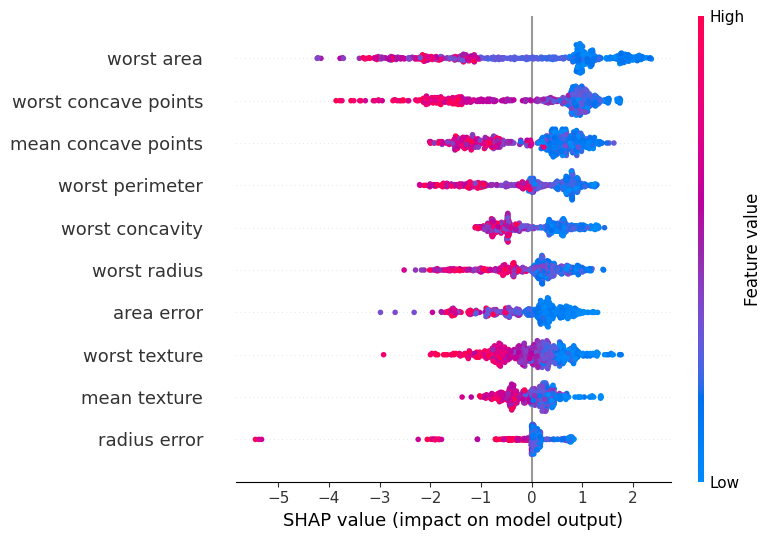

In [10]:
# Visualize SHAP distributions:
shap.summary_plot(
    ds.shap_value.sel(models='gbm').values, 
    features=ds.shap_feature.sel(models='gbm').values, 
    feature_names=ds.features.values, 
    max_display=10
)

In [56]:
# Show all feature coefficients across folds:
(
    ds.model.sel(models="lr")
    .to_dataframe()
    .assign(selected_features=lambda df: 
        df['model'].apply(lambda m: 
            tuple(zip(
                m.estimator[-1].coef_.squeeze(),
                m.estimator[:-1].get_feature_names_out()
            ))
        )
    )
    .explode('selected_features')
    .pipe(lambda df: pd.DataFrame(df['selected_features'].tolist(), index=df.index, columns=['value', 'feature']))
    .reset_index()
    .pivot(index='feature', columns='folds', values='value')
    .assign(mean=lambda df: df.mean(axis=1))
    .sort_values('mean', ascending=False)
    .style
    .format(precision=2)
    .background_gradient(axis=None, cmap='Spectral')
)

folds,0,1,2,3,4,mean
feature,,,,,,
compactness error,0.78,0.97,0.51,0.69,0.68,0.73
fractal dimension error,0.84,0.83,0.53,0.52,0.55,0.66
mean compactness,0.09,0.65,0.44,0.56,0.61,0.47
mean fractal dimension,0.42,0.08,0.34,0.29,0.44,0.31
symmetry error,0.14,0.36,0.56,0.16,0.27,0.30
texture error,0.13,0.23,0.26,0.27,0.26,0.23
mean symmetry,0.05,-0.01,0.06,0.22,-0.08,0.05
concavity error,-0.06,-0.16,0.06,0.10,0.25,0.04
worst compactness,0.01,0.28,-0.07,-0.07,-0.00,0.03


In [19]:
# Show predictions and true outcomes on test splits
ds[['prediction', 'outcome']].sel(classes='positive').to_dataframe().head()

,,,prediction,outcome,classes
index,models,outcomes,,,
R000,lr,target,9.081945e-16,0,positive
R001,lr,target,1.719733e-08,0,positive
R002,lr,target,3.225580e-08,0,positive
R003,lr,target,8.920052e-01,0,positive
R004,lr,target,2.059340e-05,0,positive


In [33]:
# Show test prediction distributions by true label
(
    ds[['prediction', 'outcome']]
    .sel(classes='positive')
    .to_dataframe()
    .reset_index()
    .groupby(['models', 'outcome'])['prediction'].describe()
    [['count', 'min', 'mean', '50%', 'max']]
    .style
    .format(precision=3)
    .background_gradient(axis=None, subset=['min', 'mean', '50%', 'max'])
    # .background_gradient(subset='count')
    .format(precision=0, subset='count')
)